In [1]:
import sys
import os

import functions
from functions import*
import matplotlib.colors as colors


### State Parameters

In [340]:
boson_dim = 6
lower_fock = 0
upper_fock = 4

one_logical = 2

#Bases
# logical_plus = np.sin((N * np.pi)/(F + 2*N - F % N)) * fock(boson_dim, 0+shift)

logical_0 = (tensor(fock(boson_dim, lower_fock),fock(boson_dim,upper_fock))/np.sqrt(2) +tensor(fock(boson_dim, upper_fock),fock(boson_dim,lower_fock))/np.sqrt(2))

logical_1 = tensor(fock(boson_dim, one_logical),fock(boson_dim,one_logical))

logical_plus = (logical_0 + logical_1).unit()
logical_minus = (logical_0 - logical_1).unit()

logical_0 = logical_0.unit()
logical_1 = logical_1.unit()

Quantum object: dims=[[6, 6], [1, 1]], shape=(36, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


/var/folders/vk/f4xd4c5n14vf35zbrzpvtz2c0000gn/T/ipykernel_89684/3969008639.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)


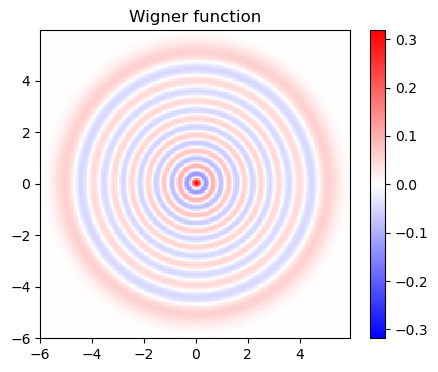

In [351]:

plt.figure(figsize=(5,4))

xvec = np.arange(-6, 6, 10.0 / 200)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)
state = logical_1
print(state)

W = wigner(state,xvec,yvec)

norm = colors.CenteredNorm( vcenter=0)

plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)
plt.colorbar();
plt.title('Wigner function')
plt.show()


### Stabilisers

In [393]:
#Operators

n_operator = num(boson_dim)
a = destroy(boson_dim)
ln_Z = 1j * 2* np.pi * n_operator / 2 #(upper_fock-lower_fock)
Z_L = ln_Z.expm()

ancilla_plus = (basis(2, 0) + basis(2, 1)).unit()
ancilla_minus = (basis(2, 0) - basis(2, 1)).unit()

ln_Z_mode1 = tensor(Z_L, identity(boson_dim))

ln_Z_mode2 = tensor(identity(boson_dim), Z_L)

# S_l = fock(cutoff, 0)*fock(cutoff, N).dag()
# for i in range(1, cutoff-N):
#     S_l += fock(cutoff, i) * fock(cutoff, i+N).dag()

#Just checking
print(expect(ln_Z_mode2, logical_plus))
print(expect(ln_Z_mode2, logical_minus))

print(expect(ln_Z_mode2, logical_0))

print(expect(ln_Z_mode2, logical_1))



coupled_Z_mode1 = tensor(sigmay(), 0.985*ln_Z_mode1).expm()
coupled_Z_mode2 = tensor(sigmay(), 0.985*ln_Z_mode2).expm()

coupled_Z_mode1 = tensor(sigmay(), 0.5*ln_Z_mode1).expm()
coupled_Z_mode2 = tensor(sigmay(), 0.5*ln_Z_mode2).expm()

coupled_Z_mode1 = tensor(sigmay(), 1/2*ln_Z_mode1).expm()
coupled_Z_mode2 = tensor(sigmay(), 1/2*ln_Z_mode2).expm()



0.9999999999999997
0.9999999999999997
0.9999999999999998
1.0


In [394]:
def stab_rounds(state, n_rounds, corrector1,corrector2):
    for i in range(n_rounds):
        state = tensor(ket2dm(basis(2, 0)), state)
        psi_new = ( corrector2 * corrector1) * state * (corrector2 * corrector1).dag()
        psi_new = psi_new / psi_new.tr()
        psi_new = psi_new.ptrace([1,2])

        state = psi_new

    return state

def logical_decay(initial_state, time_steps, delta_t, heating_rate, rounds_per_correction,disp_kick):

    psi0 = initial_state

    psi = ket2dm(psi0)
    fidelity_array = [fidelity(psi,psi0)**2]

    
    for x in range(time_steps):
        
        H = 0* tensor(identity(boson_dim),a.dag() *a) + 0* tensor(a.dag() *a,identity(boson_dim))

        times = np.linspace(0.0, delta_t, 200)
        result = mesolve(H, psi, times, [np.sqrt(heating_rate) * tensor(a,identity(boson_dim)), 
                                        np.sqrt(heating_rate) * tensor(a.dag(),identity(boson_dim)),
                                        np.sqrt(18)* tensor(a.dag()* a,identity(boson_dim)) + np.sqrt(18)* tensor(identity(boson_dim),a.dag()* a),
                                        np.sqrt(heating_rate) * tensor(identity(boson_dim),a),
                                        np.sqrt(heating_rate) * tensor(identity(boson_dim),a.dag())])

        psi = result.states[-1]
    
        if x % rounds_per_correction  == 0:
            
            psi = stab_rounds(psi, 1, coupled_Z_mode1, coupled_Z_mode2)   

        if x % rounds_per_correction == 0:
            alpha = np.random.normal(0, disp_kick) *np.exp( 1.j * np.random.uniform(0, 2*np.pi))
            beta = np.random.normal(0, disp_kick) *np.exp( 1.j * np.random.uniform(0, 2*np.pi))

            D = tensor(identity(boson_dim),displace(boson_dim, alpha))
            D = tensor(displace(boson_dim, beta),identity(boson_dim))

            psi = D * psi * D.dag()


            
        fidelity_array.append(fidelity(psi0, psi)**2)

    time_array = delta_t * np.linspace(0,1*time_steps,time_steps+1)
    return fidelity_array, time_array
        

rounds_per_correction = 7
heating_rate = 0.2 #Hz

# time step
delta_t = 10e-3

initial_state = logical_plus
time_steps = 1000
disp_kick = 0.033

fidelity_array_corrected, time_array_corrected = logical_decay(initial_state, time_steps, delta_t, heating_rate, rounds_per_correction,disp_kick)

fidelity_array_uncorrected, time_array_uncorrected = logical_decay(initial_state, time_steps, delta_t, heating_rate, rounds_per_correction*1000, disp_kick)


(-0.1, 1.1)

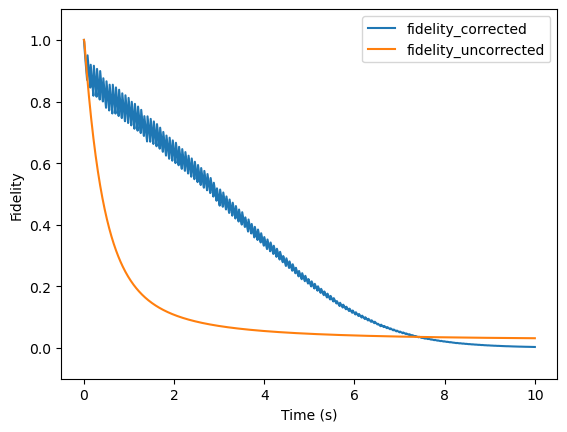

In [396]:
# plt.plot(S_l_array,label = 's_l')
plt.plot(time_array_corrected,fidelity_array_corrected,label = 'fidelity_corrected')
plt.plot(time_array_uncorrected,fidelity_array_uncorrected,label = 'fidelity_uncorrected')

plt.xlabel('Time (s)')
plt.ylabel('Fidelity')

plt.legend()
plt.ylim([-0.1,1.1])
# plt.xlim([-0.1,10.1])


In [56]:
print((psi**2).tr())
print(expect(n_operator, psi))
print((psi).tr())
print(psi.full()[0:20][0:20])

plt.matshow(np.real(psi))

0.8395944370217352


ValueError: incompatible dimensions [8] and [8, 8]

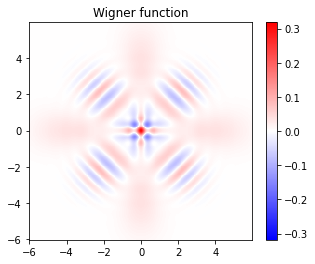

In [39]:

plt.figure(figsize=(5,4))

xvec = np.arange(-6, 6, 10.0 / 200)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)

diss_state = psi

W = wigner(diss_state,xvec,yvec)

norm = colors.CenteredNorm( vcenter=0)

plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)
plt.colorbar();
plt.title('Wigner function')
plt.show()

In [40]:


'''psi0 = logical0
psi = ket2dm(psi0)
range_epsilon = np.linspace(-1, 1, 400)
for x in range_epsilon:
    coupled_Z = tensor(sigmay(), x * ln_Z).expm()
    psi = stab_rounds(psi, 1, coupled_S_l, coupled_Z)
    print(x, fidelity(psi, logical0))'''




psi0 = logical0
psi = ket2dm(psi0)
fidelity_array_2 = [1]
S_l_array_2 = [expect(S_l, psi0).real]
time_array = delta_t * np.arange(31)

for x in range(400):
    times = np.linspace(0.0, delta_t, 200)
    result = mesolve(H, psi, times, [np.sqrt(0.001) * a, np.sqrt(0.018) * a.dag() * a])

    psi = result.states[-1]
    #psi = stab_rounds(psi, 1, coupled_S_l, coupled_Z)
    if x % 2 == 0:
        alpha = np.random.normal(0, 0.01) + 1.j * np.random.uniform(0, 0.01)
        D = displace(cutoff, alpha)
        psi = D * psi * D.dag()

    S_l_array_2.append(expect(S_l, psi).real)
    fidelity_array_2.append(fidelity(psi0, psi))

print(S_l_array_2)
print(fidelity_array_2)




TypeError: Incompatible Qobj shapes

In [ ]:
plt.plot(S_l_array_2)
plt.plot(fidelity_array_2)
plt.ylim([-0.1,1,1])
plt.show()
